In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import os
import tensorflow as tf
import keras
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
class PreProcessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter
        
    def preprocess(self, image):
        image = cv2.resize(image, (self.width,self.height),
                          interpolation=self.inter)
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
class DatasetLoader:
    def __init__(self, preprocessors= None):
        self.preprocessors = preprocessors
        
        if preprocessors == None:
            self.preprocessors = []
    def load(self, imagePaths, verbose=-1):
        #inicializar la lista y las etiquetas
        data = []
        labels = []
        
        for (i, imagePath) in enumerate(imagePaths):
            #cargar las imagenes y extraer la clase que pertenece
            image = cv2.imread(imagePath)
            imagePaths = os.path.normpath(imagePath)
            label = imagePath.split("/")[-2]
            
            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)
            data.append(image)
            labels.append(label)
            
            if verbose>0 and i>0 and (i+1)%verbose==0:
                print("[INFO] processed {}/{}".format(i+1, len(imagePaths)))
        return (np.array(data), np.array(labels))

In [4]:
#se obtiene las direcciones de todas las imagenes
impaths_train = []
impaths_test = []

for root, dirs, files in os.walk("./input/dataset/train-smoke"):
    for file in files:
        if file.endswith(".jpg"):
            impaths_train.append(os.path.join(root, file))
            
            
for root, dirs, files in os.walk("./input/dataset/test_big"):
    for file in files:
        if file.endswith(".jpg"):
            impaths_test.append(os.path.join(root, file))

In [5]:
#definir el proceso de las imagenes
height, width = 32, 32
prep = PreProcessor(height, width)
#Cargar el conjuto de imagenes
load_data = DatasetLoader([prep])
print("Preprocesando los datos de entrenamiento...")
data_train = load_data.load(impaths_train, verbose=500)
print("Datos de entrenamiento preparados! \nProcessing Test data...")
data_test = load_data.load(impaths_test, verbose=500)
print("Datos de prueba preparadas!")

Preprocesando los datos de entrenamiento...
[INFO] processed 500/36
[INFO] processed 1000/36
[INFO] processed 1500/36
[INFO] processed 2000/36
[INFO] processed 2500/36
[INFO] processed 3000/36
[INFO] processed 3500/36
[INFO] processed 4000/36
[INFO] processed 4500/36
[INFO] processed 5000/36
[INFO] processed 5500/36
[INFO] processed 6000/36
[INFO] processed 6500/36
[INFO] processed 7000/36
[INFO] processed 7500/36
[INFO] processed 8000/36
[INFO] processed 8500/36
[INFO] processed 9000/36
[INFO] processed 9500/36
[INFO] processed 10000/36
[INFO] processed 10500/36
[INFO] processed 11000/36
[INFO] processed 11500/36
[INFO] processed 12000/36
[INFO] processed 12500/36
Datos de entrenamiento preparados! 
Processing Test data...
[INFO] processed 500/33
[INFO] processed 1000/33
[INFO] processed 1500/33
[INFO] processed 2000/33
Datos de prueba preparadas!


In [6]:
X_train, y_train_etiq = data_train
X_test1, y_test_etiq = data_test
# se lsita el tamaño de cada data set y a demas se considera 
# el tamaño de cada img incluyendo la distribución de rgb
print(X_train.shape, X_test1.shape)

(12620, 32, 32, 3) (2007, 32, 32, 3)


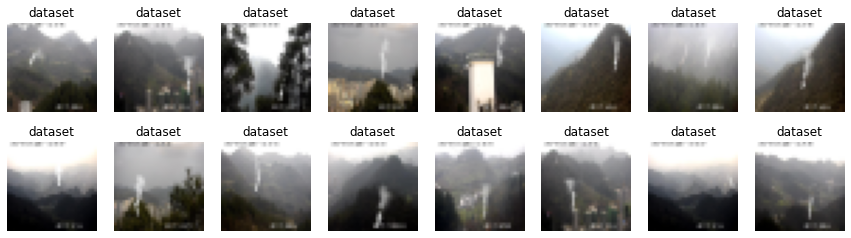

In [7]:
# imprimir imagenes aleatorias del conjunto de datos del entrenamiento
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train_etiq))
        ax = fig.add_subplot(rows, cols, i * rows + j +1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index])
        ax.set_title(y_train_etiq[random_index])
plt.show()

In [8]:
y_train1 = np.array([0 if y_train_etiq[i] == 'Blackrot'
                    else 1 for i in
                    range(len(y_train_etiq))]).reshape((len(y_train_etiq),1))


y_test1 = np.array([0 if y_test_etiq[i] == 'Blackrot'
                    else 1 for i in
                    range(len(y_test_etiq))]).reshape((len(y_test_etiq),1))
print(y_train1.shape, y_test1.shape)

(12620, 1) (2007, 1)


In [9]:
#Normalizar las imagenes
num_classes = 2
X_trainF = X_train / 255. - 0.5
X_testF = X_test1 / 255. - 0.5

#convertir las clases de las imagenes en vectores one-hot
y_train = tf.keras.utils.to_categorical(y_train1, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test1, num_classes=2)

In [10]:
#importar las capas necesarias para contruir la red
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from ipywidgets import IntProgress

In [11]:
def define_model():
    model = Sequential()
    #Se define la estructura del modelo
    model.add(Conv2D(16, (3, 3), strides=(1,1), padding="same",
                    input_shape=(height, width, 3)))               #Convolutional
    model.add(LeakyReLU(0.3))                                      #activación
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))   #convolutional
    model.add(LeakyReLU(0.1))                                      #activation
    model.add(MaxPooling2D(pool_size=(2,2)))                       #pooling
    model.add(Dropout(0.25))                                       #dropout
    model.add(Conv2D(32, (3, 3), strides=(1,1), padding="same"))   #convolutional
    model.add(LeakyReLU(0.3))                                      #activation
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))  #convolutional
    model.add(LeakyReLU(0.3))                                      #activation
    model.add(MaxPooling2D(pool_size=(2, 2)))                      #pooling
    model.add(Dropout(0.25))                                       #dropout
    model.add(Flatten())                                           #flatten
    model.add(Dense(256))                                          #dense
    model.add(LeakyReLU(0.1))                                      #activation
    model.add(Dropout(0.5))                                        #dropout
    model.add(Dense(num_classes))                                  #DENSE
    model.add(Activation("softmax"))
    
    return model
    

In [12]:
# Resumen del modelo
s = tf.keras.backend.clear_session()
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

In [15]:
#fase de entranamiento del modelo
init_lr = 9e-3 #se implementa para el algoritmo de desecenso del radiante
BATCH_SIZE = 32
EPOCHS = 12

s = tf.keras.backend.clear_session()
model = define_model()


model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate=init_lr),
    metrics = ['accuracy'] # especifica la precision durante el modelo
)

#ajustar el ratio de aprendizaje en su entrenamiento
def lr_scheduler(epoch):
    return init_lr * 0.9 ** epoch

class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate: ", K.get_value(model.optimizer.lr))


In [16]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = model.fit(
    X_trainF, y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler),
              LrHistory(),
              tqdm_callback],
    validation_data=(X_testF, y_test),
    shuffle = True,
    verbose = 5,
    initial_epoch = 0
)

Training:   0%|                                                                                0/12 ETA: ?s,  …

Epoch 1/12
Learning rate:  0.009
Epoch 1/12


0/395                                                                                                        E…

Epoch 2/12
Learning rate:  0.0081
Epoch 2/12


0/395                                                                                                        E…

Epoch 3/12
Learning rate:  0.00729
Epoch 3/12


0/395                                                                                                        E…

Epoch 4/12
Learning rate:  0.006561
Epoch 4/12


0/395                                                                                                        E…

Epoch 5/12
Learning rate:  0.0059049
Epoch 5/12


0/395                                                                                                        E…

Epoch 6/12
Learning rate:  0.00531441
Epoch 6/12


0/395                                                                                                        E…

Epoch 7/12
Learning rate:  0.004782969
Epoch 7/12


0/395                                                                                                        E…

Epoch 8/12
Learning rate:  0.004304672
Epoch 8/12


0/395                                                                                                        E…

Epoch 9/12
Learning rate:  0.0038742048
Epoch 9/12


0/395                                                                                                        E…

Epoch 10/12
Learning rate:  0.0034867844
Epoch 10/12


0/395                                                                                                        E…

Epoch 11/12
Learning rate:  0.0031381059
Epoch 11/12


0/395                                                                                                        E…

Epoch 12/12
Learning rate:  0.0028242953
Epoch 12/12


0/395                                                                                                        E…